# Multidimensional Analysis

In this notebook, we'll be show you how to perform multidimensional analysis, allowing users to observe data from different viewpoints.

<div style="text-align: center;"><img src="https://data.atoti.io/notebooks/multidimension/img/cube-slice-dice.png"></div>

<div style="text-align:center"><a href="https://www.atoti.io/?utm_source=gallery&utm_content=multidimensional-analysis" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Discover-Atoti-now.png" alt="atoti table" /></a></div>

In [1]:
import pandas as pd
import atoti as tt

In [2]:
session = tt.Session.start()

In [3]:
sales = session.read_csv(
    "s3://data.atoti.io/notebooks/multidimension/sales.csv",
    types={"Unit price": tt.type.DOUBLE},
)
sales.head()

,Sale ID,Date,Shop,Product,Quantity,Unit price
0,S000003722,2021-02-02,shop_2,TAB_1,3,300.0
1,S000000059,2021-01-06,shop_19,SHO_59,2,60.0
2,S000003071,2021-01-24,shop_31,TAB_21,1,210.0
3,S000001550,2021-01-15,shop_30,BED_25,1,300.0
4,S000001790,2021-01-15,shop_30,TAB_21,1,210.0


In [4]:
cube = session.create_cube(sales, "sales cube")

# Data are group into two categories - Data dimensions and measurements

In [5]:
cube

<img alt="Multidimensional cube concept" src="https://data.atoti.io/notebooks/multidimension/img/cube-concept.svg" width="400" />

The axes of the cube are called _hierarchies_.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
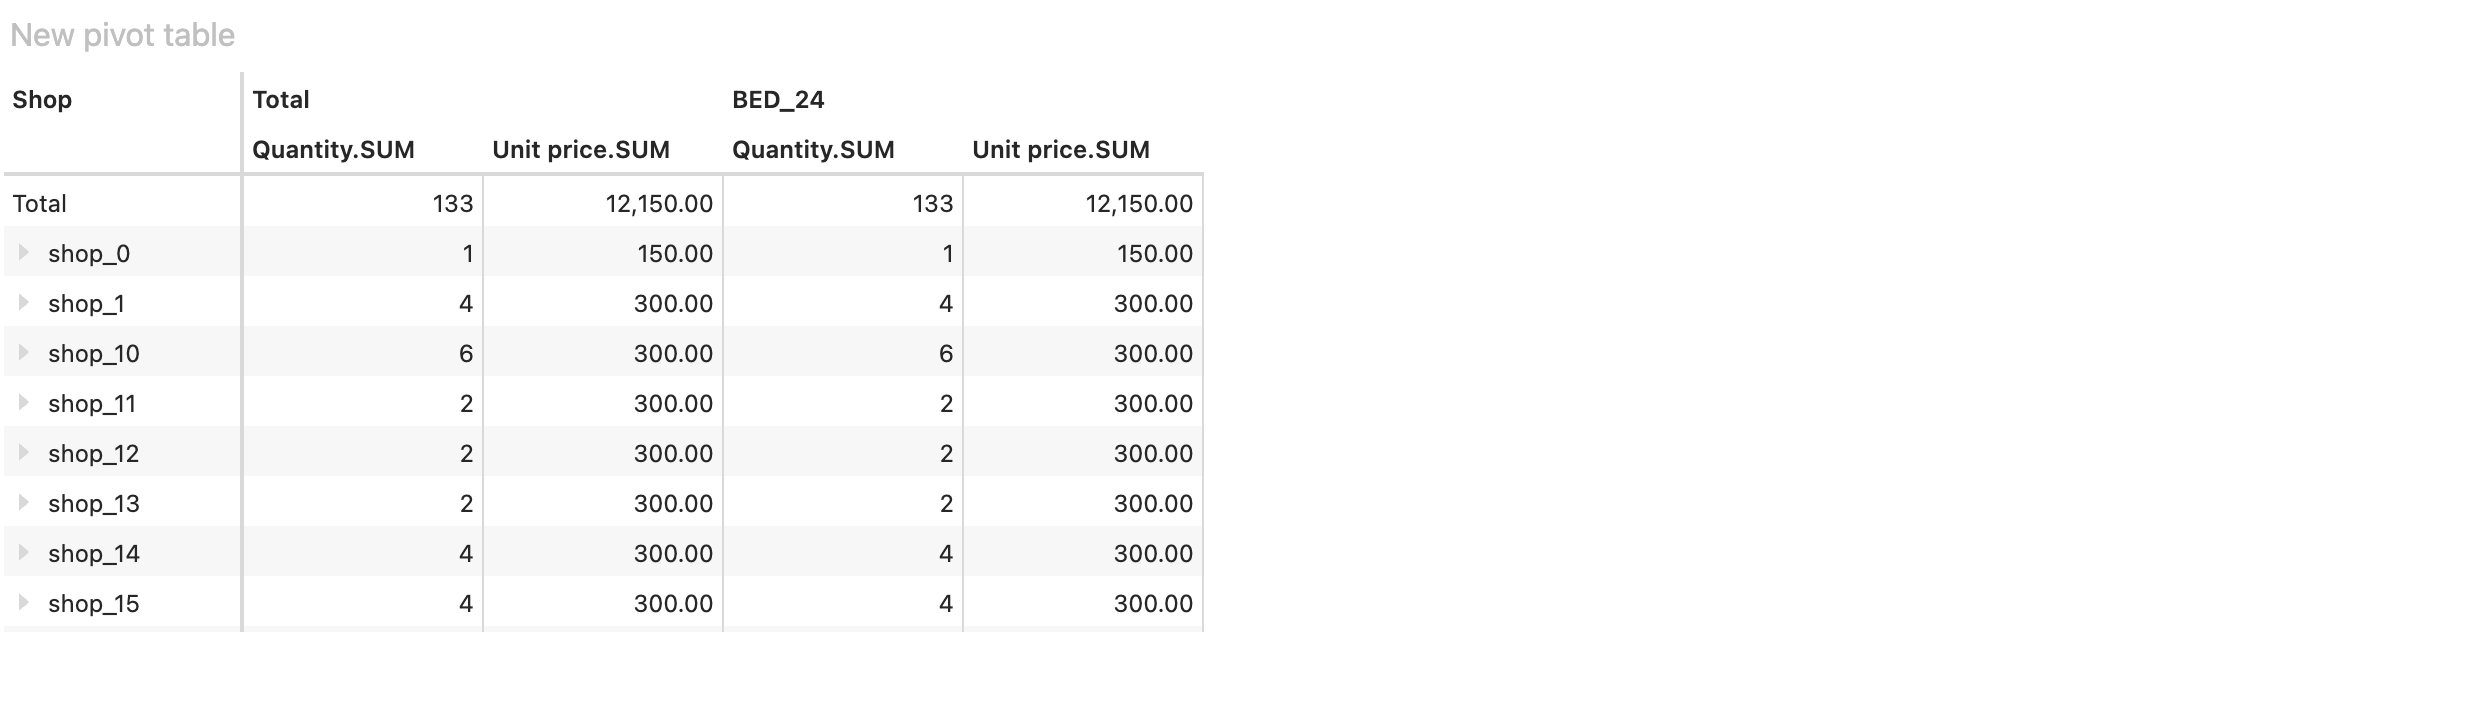

In [6]:
session.widget

# Capable of integrating multiple data sources 

In [7]:
products = session.read_csv(
    "s3://data.atoti.io/notebooks/multidimension/products.csv", keys=["Product"]
)
products.head()

,Category,Sub category,Size,Purchase price,Color,Brand
Product,,,,,,
HOO_12,Cloth,Hoodie,S,35.0,blue,Basic
BED_26,Furniture,Bed,Queen,333.0,white,Basic
SHO_40,Cloth,Shoes,11,48.0,black,Basic
HOO_54,Cloth,Hoodie,S,35.0,brown,Over
HOO_13,Cloth,Hoodie,M,38.0,red,Mega


In [8]:
sales.join(products)
session.tables.schema

URLError: <urlopen error [Errno 54] Connection reset by peer>

erDiagram
  "Products" {
    _ String PK "Product"
    _ String "Category"
    _ String "Sub category"
    _ String "Size"
    nullable double "Purchase price"
    _ String "Color"
    _ String "Brand"
  }
  "Sales" {
    _ String "Sale ID"
    _ LocalDate "Date"
    _ String "Shop"
    _ String "Product"
    nullable int "Quantity"
    nullable double "Unit price"
  }
  "Sales" }o--o| "Products" : "`Product` == `Product`"

In [9]:
h, l, m = cube.hierarchies, cube.levels, cube.measures

In [10]:
h

{('Products', 'Category'): <atoti.hierarchy.Hierarchy object at 0x11d592f50>, ('Products', 'Size'): <atoti.hierarchy.Hierarchy object at 0x11d593f10>, ('Products', 'Color'): <atoti.hierarchy.Hierarchy object at 0x11d592aa0>, ('Products', 'Sub category'): <atoti.hierarchy.Hierarchy object at 0x11d5c8250>, ('Products', 'Brand'): <atoti.hierarchy.Hierarchy object at 0x11d5c82b0>, ('Sales', 'Shop'): <atoti.hierarchy.Hierarchy object at 0x11d5c8310>, ('Sales', 'Date'): <atoti.hierarchy.Hierarchy object at 0x11d5c8370>, ('Sales', 'Product'): <atoti.hierarchy.Hierarchy object at 0x11d5c83d0>, ('Sales', 'Sale ID'): <atoti.hierarchy.Hierarchy object at 0x11d5c8430>}

In [11]:
h["Product categories"] = [l["Category"], l["Sub category"]]

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
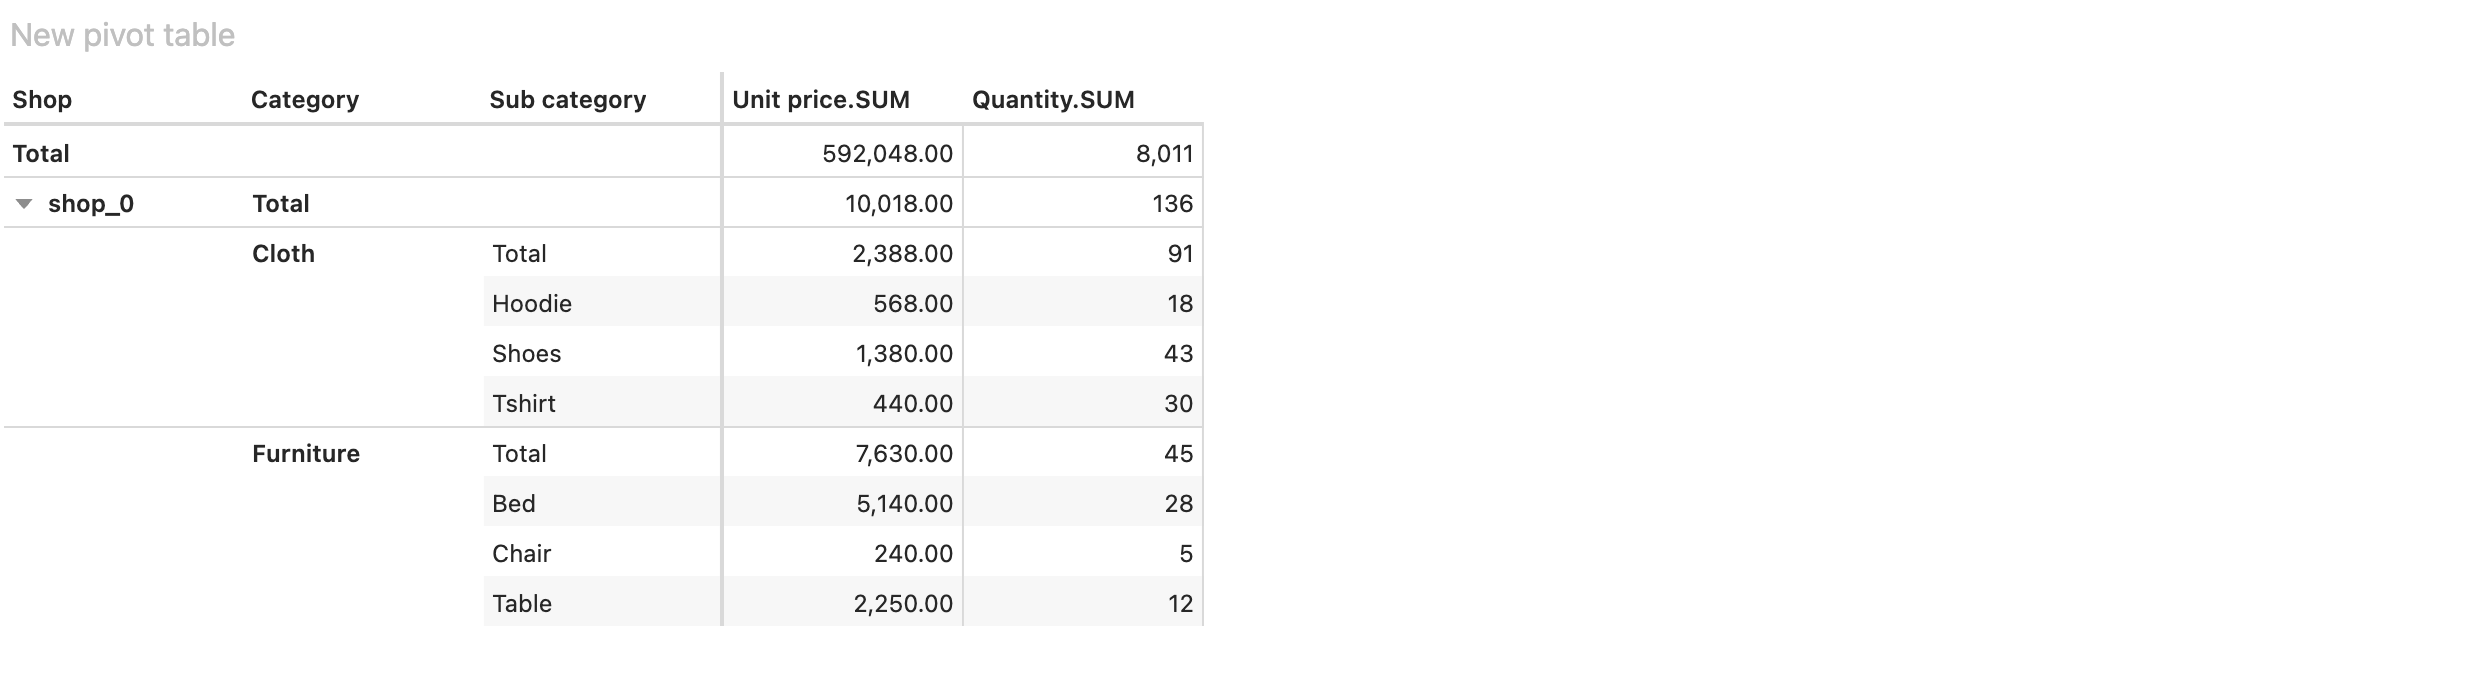

In [12]:
session.widget

# Aggregational flexibility - Pre-processing vs Post-processing



## Pre-processing trades storage consumption for computational efficiency

In [13]:
product_df = pd.read_csv("https://data.atoti.io/notebooks/multidimension/products.csv")
product_df.head()

,Product,Category,Sub category,Size,Purchase price,Color,Brand
0,TAB_0,Furniture,Table,1m80,190.0,black,Basic
1,TAB_1,Furniture,Table,2m40,280.0,white,Mega
2,CHA_2,Furniture,Chair,NaN,48.0,blue,Basic
3,BED_3,Furniture,Bed,Single,127.0,red,Mega
4,BED_4,Furniture,Bed,Double,252.0,brown,Basic


In [ ]:
sales_df = pd.read_csv("https://data.atoti.io/notebooks/multidimension/sales.csv")
sales_df.head()

Within the same data source, we can easily perform aggregation by applying the formulas. Notice that our dataset just grew bigger with the additional column? By loading this dataset, we traded storage consumption for the computational efficiency because the cube need not compute the sales amount every time we query it.

In [ ]:
sales_df["Sales amount"] = sales_df["Quantity"] * sales_df["Unit price"]
sales_df.head()

When aggregation involves multiple data sources, then we need to handle the joins before we can apply the formulas.

In [ ]:
product_sales = pd.merge(sales_df, product_df, on="Product")
product_sales.head()

In [ ]:
product_sales["Cost price"] = (
    product_sales["Quantity"] * product_sales["Purchase price"]
)
product_sales["Margin"] = sales_df["Sales amount"] - product_sales["Cost price"]
product_sales.head()

Pre-processing works when we are at the most granular level because we will still be able to drill down or roll up. At higher aggregation level, we will not know how to break the value when we drill down to the lower level.

<div style="text-align: center;"><img src="https://data.atoti.io/notebooks/multidimension/img/drilldown_rollup.png" width="50%"></div>

## Post-processing computes on the fly and provides flexibility

In [ ]:
h, l, m = cube.hierarchies, cube.levels, cube.measures

In [ ]:
m["Sales amount"] = tt.agg.sum(
    sales["Quantity"] * sales["Unit price"],
)

In [ ]:
m["Cost price"] = tt.agg.sum(
    m["Quantity.SUM"] * tt.agg.single_value(products["Purchase price"]),
    scope=tt.OriginScope(levels={l["Product"]}),
)

In [ ]:
m["Margin"] = m["Sales amount"] - m["Cost price"]

In [ ]:
m["Cumulative amount"] = tt.agg.sum(
    m["Sales amount"], scope=tt.CumulativeScope(level=l["Date"])
)

m["Cumulative margin"] = tt.agg.sum(
    m["Margin"], scope=tt.CumulativeScope(level=l["Date"])
)

In the visualization below, we are missing the sales data for `Shop_0` on 15 Jan 2021. Suppose we use pre-processing computation to get the cumulative values, we will need to perform re-calculation and then reload the data into the cube. With post-processing, this is not required as the data is computed on the fly.

In [ ]:
session.widget

In [ ]:
session.widget

Simply load the missing data into the cube and it will be computed automatically.

In [ ]:
sales.load_csv("s3://data.atoti.io/notebooks/multidimension/shop0_20210115.csv")

Re-running the last 2 visualizations should reflect the correct sales.

<div style="text-align:center"><a href="https://www.atoti.io/?utm_source=gallery&utm_content=multidimensional-analysis" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Your-turn-to-try-Atoti.jpg" alt="Atoti table" /></a></div>